# Midterm 1

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Instructions

## Please note the following:

Points
* The exam is `100` points.
* You have `125` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.


Submission
* You will upload your solution to the `Midterm 1` assignment on Canvas, where you downloaded this. (Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers,)
* and it should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `midterm_1_data.xlsx`

This file has sheets for...
* `stocks excess returns` - excess returns of the 14 biggest companies in the S&P.
* `proshares excess returns` - excess returns of ETFs and indexes from the Proshares case study.
* `fx carry excess returns` - excess returns from FX products.

Note the data is **monthly** for the first two sheets (stocks and proshares). Any annualizations for those two sheets should use `12` months in a year. Annualization for the third sheet (fx carry excess returns) is explained in section 4.

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 15     |
| 2       | 25     |
| 3       | 35     |
| 4       | 25     |

### Each numbered question is worth 5 points unless otherwise specified.

***

# 1. Short Answer

#### No Data Needed

These problems do not require any data file. Rather, analyze them conceptually. 

### 1.

#### (10pts)

In the mean-variance optimization of `homework 1`, suppose we found the mean excess return of TIPS is 4% annualized.

Explain--conceptually--how each of the following would have impacted the new (with TIPS) MV solution.
* TIPS is found to have correlation of 0% to `IEF` and 0% to SPY.
* TIPS is found to have correlation of 100% to `IEF`.

Would it be possible for TIPS to have been found to have 0% correlation to every other asset in `homework 1`? Explain.

TIPS already had quite a low correlation to our portfolio, and that is why it was so valuable, because it reduced the risk profile of our portfolio via diversification. If it would have had a 0% correlation, then that would have made it even more valuable. However, if it was highly corelated to IEF, than we would not have gained as much benefit from it. IEF is the ticker for 10 year treasury bonds, so including another highly correlated bond wouldn't have been very valuable unless TIPS had a large return. It is very unlikely TIPS would have a 0% correlation to the assets. Since there were already bonds in the portfolio, it was bond to have some sort of correlation with them as they share similar properties, like sensitivity to interest rates, etc.

### 2. 

Depending on the application, one may or may not choose to include an intercept term in a linear factor decomposition of an asset’s returns. In what circumstances would I prefer to include an intercept, and in what circumstances would I not?

An intercept makes sense when the intercept is investible. For example, if the intercept is the risk free rate, then we can absolutely use it. However, in the case when it is not investible, like in our example about replicating hedge fund returns where the intercept represented the alpha hedge funds generate, we cannot easily invest in it, and should not include it.

***

# 2. Portfolio Allocation

For this question you will only use data from the sheet `stocks excess returns`.

It contains excess returns for the 14 largest stocks in the S&P.

### 1.

Calculate the tangency portfolio from the start of the sample to December of 2018 (to 2018-12-31), which we call in-sample period. Use the following methods:
- Traditional tangency portfolio.
- Regularized tangency portfolio (divide by 2 every element outside of the diagonal in the covariance matrix prior to the calculation).

Return:
- The weights of each asset for the traditional tangency portfolio and the regularized tangency portfolio.
- The sum of absolute values of the weights for the traditional tangency portfolio and the regularized tangency portfolio:

$$
\sum_{i=1}^{n} |w_i|
$$


In [387]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

In [388]:
#import data

FILEIN = '../data/midterm_1_data.xlsx'
sheet_exrets = 'stocks excess returns'
retsx = pd.read_excel(FILEIN, sheet_name=sheet_exrets).set_index('date')

retsx.head()

,AAPL,AMZN,BRK-B,GOOGL,JNJ,JPM,LLY,META,MSFT,NVDA,TSLA,UNH,V,XOM
date,,,,,,,,,,,,,,
2012-06-30,0.010943,0.072609,0.050116,-0.001270,0.082263,0.077918,0.047953,0.050766,0.048052,0.111916,0.060768,0.052919,0.073267,0.088352
2012-07-31,0.045822,0.021677,0.018121,0.091196,0.024570,0.015958,0.026101,-0.301929,-0.036613,-0.020260,-0.123682,-0.126667,0.044002,0.014958
2012-08-31,0.093695,0.063985,-0.006075,0.082161,-0.017188,0.031486,0.031399,-0.168306,0.052556,0.036008,0.039935,0.062649,-0.004849,0.011533
2012-09-30,0.002878,0.024450,0.045849,0.101397,0.022030,0.090012,0.055749,0.199417,-0.034312,-0.049099,0.026730,0.024657,0.047099,0.047619
2012-10-31,-0.107527,-0.084192,-0.020903,-0.098271,0.027789,0.037321,0.025805,-0.025320,-0.040922,-0.101877,-0.039204,0.010720,0.033436,-0.002989


In [389]:
#splitting up in sample and out of sample data
retsx_IS = retsx.loc[:'2018']
retsx_OOS = retsx.loc['2019':]

In [390]:
#using the function from the practice midterm for the tangency portfolio

def tangency_weights(returns, cov_mat = 1):
    
    if cov_mat ==1:
        cov_inv = np.linalg.inv((returns.cov()*12))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag((cov)))
        covmat = cov_mat * cov + (1-cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat*12))  
        
    ones = np.ones((returns.shape[1], 1))

    mu = returns.mean().values.reshape(-1, 1)  # Convert mu to a column vector

    scaling = 1 / (ones.T @ cov_inv @ mu)  # Transpose ones to make it a row vector
    
    tangent_return = scaling*(cov_inv @ mu)

    tangency_wts = pd.DataFrame(index = returns.columns[:], data = tangent_return[:], columns = ['Tangent Weights'] )
        
    return tangency_wts

In [391]:
wts = pd.DataFrame(index = retsx_IS.columns, columns=['tangency','regularized'])
wts.loc[:,'tangency'] = tangency_weights(retsx_IS, cov_mat = 1).values
wts.loc[:,'regularized'] = tangency_weights(retsx_IS, cov_mat = (1/2)).values #regularizing by a factor of 1/2 as indicated in the question
wts

,tangency,regularized
AAPL,-0.127836,-0.014706
AMZN,-0.040576,0.03631
BRK-B,0.131333,0.109162
GOOGL,0.025968,0.050545
JNJ,0.130408,0.09919
JPM,-0.013929,0.053691
LLY,0.352670,0.214949
META,0.030541,0.034896
MSFT,0.137917,0.08997
NVDA,0.163501,0.071696


In [392]:
#chat GPT prompt: get absoulte value of each row in a data frame
wts_absolute = wts.abs()
sum_absolute = wts_absolute.sum()
sum_absolute

tangency       2.197687
regularized    1.342647
dtype: object

### 2.

Calculate the annualized summary statistics (mean, Sharpe, vol) of both portfolios in-sample.


In [393]:
#importing performance summary code from practice midterm

def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """

    if isinstance(return_data, pd.Series):
        return_data = return_data.to_frame('Returns') 
        
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [394]:
tan_statistics = performance_summary(retsx_IS @ wts['tangency'] , 12)
reg_statistics = performance_summary(retsx_IS @ wts['regularized'] , 12)

summary_df = pd.DataFrame(columns=['Mean', 'Volatility', 'Sharpe Ratio'])
selected_columns1 = tan_statistics[['Mean', 'Volatility', 'Sharpe Ratio']]
selected_columns1.index = ['Tangency Portfolio']

selected_columns2 = reg_statistics[['Mean', 'Volatility', 'Sharpe Ratio']]
selected_columns2.index = ['Regularized Portfolio']

summary_df = pd.concat([summary_df, selected_columns1])
summary_df = pd.concat([summary_df, selected_columns2])
summary_df


,Mean,Volatility,Sharpe Ratio
Tangency Portfolio,0.348256,0.134053,2.597896
Regularized Portfolio,0.276599,0.114184,2.422392


### 3.

Use the weights calculated in question (2.2) to produce portfolio returns out-of-sample for both the Traditional and Regularized portfolio (from January 2019 onwards). 

Report the **last 3 returns** of both portfolios in the out-of-sample (the traditional tangency portfolio and the regularized tangency portfolio).

In [395]:
#Chat GPT prompt: how to calulcate these weights vs these returns to calcualte a new weighted returns dataframe 
weighted_returns_tangency = retsx_OOS * wts['tangency'].values
weighted_returns_regularized = retsx_OOS * wts['regularized'].values

total_weighted_returns_tangency = weighted_returns_tangency.sum(axis=1)
total_weighted_returns_regularized = weighted_returns_regularized.sum(axis=1)

starting_value = 1000

tangency_portfolio_value = starting_value * (1 + total_weighted_returns_tangency).cumprod()
regularized_portfolio_value = starting_value * (1 + total_weighted_returns_regularized).cumprod()

print("Last 3 Portfolio Values:")
print("Tangency Portfolio")
print(tangency_portfolio_value.tail(3))

print("\n")

print("Regularized Portfolio")
print(regularized_portfolio_value.tail(3))

Last 3 Portfolio Values:
Tangency Portfolio
date
2024-07-31    5033.416466
2024-08-31    5543.002099
2024-09-30    5403.529786
dtype: float64


Regularized Portfolio
date
2024-07-31     4040.67216
2024-08-31      4301.8046
2024-09-30    4230.921856
dtype: object


### 4.

Report the annualized summary statistics (Mean, Vol and Sharpe) of both portfolios in the out-of-sample.

Note: you are using the weights optimized for the in-sample and generating statistics with the out-of-sample returns.

In [396]:
tan_statistics = performance_summary(retsx_OOS @ wts['tangency'] , 12)
reg_statistics = performance_summary(retsx_OOS @ wts['regularized'] , 12)

summary_df = pd.DataFrame(columns=['Mean', 'Volatility', 'Sharpe Ratio'])
selected_columns1 = tan_statistics[['Mean', 'Volatility', 'Sharpe Ratio']]
selected_columns1.index = ['Tangency Portfolio']

selected_columns2 = reg_statistics[['Mean', 'Volatility', 'Sharpe Ratio']]
selected_columns2.index = ['Regularized Portfolio']

summary_df = pd.concat([summary_df, selected_columns1])
summary_df = pd.concat([summary_df, selected_columns2])
summary_df

,Mean,Volatility,Sharpe Ratio
Tangency Portfolio,0.321558,0.222352,1.446167
Regularized Portfolio,0.268686,0.176334,1.523729


### 5.
Which portfolio has better adjusted by risk returns in the out-of-sample? Could there be a mathematical/optimization reason why one portfolio had better adjusted by risk performance? 

Relate your answer to your findings in question (2.2) (Sum of absolute weights in the traditional and regularized tangency portfolio.)

The regularized portfolio has better performance out of sample, which is what we saw in HW1. This is due to the way we "optimize" our portfolio. The matrix math ends up causing some weights to be too extreme without regularization, which is why the abs value of weights for the tangency portfolio are higher, causing the model to perform fine in sample but struggle out of sample.

***

# 3. Hedging and Replication

For this question you will only use data from the sheet `proshares returns`.

The following assets excess returns are available in this sheet:

- **HDG US Equity**: ProShares Hedge Replication ET
- **QAI US Equity**: NYLI Hedge Multi-Strategy Trac
- **SPY US Equity**: SPDR S&P 500 ETF Trust
- **EEM US Equity**: iShares MSCI Emerging Markets
- **EFA US Equity**: iShares MSCI EAFE ETF
- **EUO US Equity**: ProShares UltraShort Euro
- **IWM US Equity**: iShares Russell 2000 ETF
- **SPXU US Equity**: ProShares UltraPro Short S&P 5
- **UPRO US Equity**: ProShares UltraPro S&P 500

In [397]:
FILEIN = '../data/midterm_1_data.xlsx'
sheet_exrets = 'proshares excess returns'
retidx = pd.read_excel(FILEIN, sheet_name=sheet_exrets).set_index('date')

retidx.head()

,HDG US Equity,QAI US Equity,SPY US Equity,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,SPXU US Equity,UPRO US Equity
date,,,,,,,,,
2011-08-31,-0.027036,-0.006489,-0.054976,-0.092549,-0.087549,-0.005889,-0.088913,0.056476,-0.210854
2011-09-30,-0.032466,-0.022141,-0.069420,-0.179063,-0.108082,0.142180,-0.111505,0.190006,-0.207003
2011-10-31,0.050531,0.025239,0.109147,0.162986,0.096274,-0.069502,0.151011,-0.298828,0.326066
2011-11-30,-0.028608,-0.007964,-0.004064,-0.019724,-0.021765,0.054627,-0.003784,-0.035515,-0.033502
2011-12-31,0.012875,0.001822,0.010449,-0.042649,-0.021744,0.075581,0.005144,-0.051986,0.022939


### 1. 

You work at a hedge fund.

Suppose the hedge fund is long $1 million of HDG and wants to hedge the position.

A junior analyst suggests that we can hedge our position by looking at some select ETFs, and then taking a position in the ETFs that will offset the risk of our HDG position.

They pick QAI, SPY, EEM, UPRO, SPXU, IWM, and EFA.

What dollar position would we be taking in each ETF to hedge your HDG position?

In [398]:
#bringing this in from the practice midterm

y = retidx['HDG US Equity']   
X = sm.add_constant(retidx[['QAI US Equity', 'SPY US Equity', 'EEM US Equity', 'UPRO US Equity', 'SPXU US Equity', 'IWM US Equity', 'EFA US Equity']])
model = sm.OLS(y,X).fit()

betas = model.params

exposure = betas * -1_000_000
exposure = exposure.drop('const')
exposure = pd.DataFrame(exposure, columns=['HDG US Equity'])
exposure.index = exposure.index.str.replace('Beta', '')
exposure.loc['Total'] = exposure.sum()
exposure['HDG US Equity'] = exposure['HDG US Equity'].map('${:,.0f}'.format)

exposure

,HDG US Equity
QAI US Equity,"$-151,537"
SPY US Equity,"$-515,376"
EEM US Equity,"$-44,816"
UPRO US Equity,"$140,222"
SPXU US Equity,"$-32,654"
IWM US Equity,"$-139,036"
EFA US Equity,"$-117,000"
Total,"$-860,198"


### 2.

#### (7pts)
What is the gross notional of the hedge?

What is the R-squared of the hedge?

What do these two statistics indicate about the practical use of this hedge?

In [399]:
rsquared = model.rsquared
rsquared

0.9128835765562017

The gross notional of this hedge is about negative $860k, and the RSquared is fairly high, at about .91. This means while we can hedge HDG effectively, it is going to require a LOT of capital, almost an equivalent amount as the long position. This will not be optimal from a liquidity point of view.

### 3.

Suppose instead we don't want to hedge our position. We believe that the value of HDG can be *entirely* determined by some combination of the other ETFs. 

So, you propose the following model:

$$
HDG_t = \beta_1 QAI_t + \beta_2 SPY_t + \beta_3 EEM_t + \varepsilon_t
$$

We think any difference between the value of HDG and the value of the ETFs is a mispricing, and will revert to 0 in the future. We call such a strategy "trading the residuals".

Therefore, if $\varepsilon_t > 0$, we should be short HDG and long the basket, and if $\varepsilon_t < 0$, we should be long HDG and short the basket.

Now...
* Run the model specified above and report the $\beta$'s values.
* After, create the "basket" portfolio, using the $\beta$'s as weights (they do not need to add up to one). Report the final three values.

In [400]:
y = retidx['HDG US Equity']   
X = sm.add_constant(retidx[['QAI US Equity', 'SPY US Equity', 'EEM US Equity']])
model = sm.OLS(y,X).fit()

betas = model.params
betasdf = betas.to_frame().drop('const')
betasdf.columns = ['Betas']

betasdf

,Betas
QAI US Equity,0.341458
SPY US Equity,0.176273
EEM US Equity,0.083082


In [401]:
#chat gpt: how do i use these betas as weights to use their raw returns to create weighted returns in python 
retidxfitlered = retidx[['QAI US Equity', 'SPY US Equity', 'EEM US Equity']]
betas = betasdf['Betas']
weighted_returns = retidxfitlered.mul(betas, axis=1)
basketreturns = weighted_returns.sum(axis=1)

starting_value = 1000
portfolio_value = starting_value * (1 + basketreturns).cumprod()

print("Last 3 Portfolio Values:")
print(portfolio_value.tail(3))

Last 3 Portfolio Values:
date
2024-07-31    1560.825130
2024-08-31    1572.597945
2024-09-30    1593.733392
dtype: float64


### 4.

#### (8pts)

Construct the strategy indicated by the approach in the previous problem.

For a given period $t$:
- if the $\varepsilon_t \leq 0$ (is negative or equal to 0), you should be long HDG 200% in HDG and short 100% in the basket portfolio **in period $t+1$**.
- if the $\varepsilon_t > 0$ (is positive), you should be long 200% in the basket portfolio and short 100% **in HDG in period $t+1$**.

Do not worry about the look forward bias: in this scenario, you should run the model only once with the entire dataset and define your $\varepsilon_t$ for any $t$ also considering the model that has acess to data in $t+1, t+2, ...$ to make the calculation.  

Report the annualized summary statistics of this strategy (Mean, Vol and Sharpe).

In [402]:
#not really sure if this is working, i feel like i am missing something.... the results seem messed up.
#chat gpt prompt: how would i approach this question using my previous regrssion

strategy_returns = []
y_pred = model.predict(X)
epsilon = y - y_pred

for i in range(len(epsilon)):
    if epsilon[i] <= 0:
        strategy_return = y[i] - basketreturns[i]
    else:
        strategy_return = basketreturns[i] - y[i]
    strategy_returns.append(strategy_return)

strategy_returns = pd.Series(strategy_returns)

mean_return = strategy_returns.mean()
volatility = strategy_returns.std()
sharpe_ratio = mean_return / volatility

print("Annualized Mean Return:", mean_return)
print("Annualized Volatility:", volatility)
print("Sharpe Ratio:", sharpe_ratio)


Annualized Mean Return: -0.005065135702811191
Annualized Volatility: 0.004359808761221946
Sharpe Ratio: -1.1617793302914414


### 5.

On a different matter, we are now studying QAI and want to track (replicate) it using the other available ETFs.

Use an intercept and report:

- $\beta$ (and the sum of $\beta$'s absolute value).
- $\alpha$ and Information Ratio.
- $R^2$.
- Correlation matrix between the assets used to replicate QAI.

In [403]:
y = retidx['QAI US Equity']   
#should have just dropped QAI below, oops
X = sm.add_constant(retidx[['HDG US Equity','SPY US Equity','EEM US Equity','EFA US Equity','EUO US Equity','IWM US Equity','SPXU US Equity','UPRO US Equity']])
model = sm.OLS(y,X).fit()

In [404]:
betas = model.params
betas

const            -0.000525
HDG US Equity     0.231451
SPY US Equity     0.565072
EEM US Equity     0.047792
EFA US Equity     0.032642
EUO US Equity    -0.020484
IWM US Equity    -0.000157
SPXU US Equity    0.051074
UPRO US Equity   -0.095099
dtype: float64

In [405]:
betas.abs().sum()

1.0442958943860663

In [406]:
intercept = model.params['const']
intercept

-0.000524683277264027

In [407]:
#chat GPT: how would i get the information ratio

predicted_returns = model.predict(X)
benchmark_returns = retidx['QAI US Equity']
active_returns = predicted_returns - benchmark_returns
average_active_return = np.mean(active_returns)
tracking_error = np.std(active_returns)
information_ratio = average_active_return / tracking_error


print("Information Ratio:", information_ratio)

Information Ratio: 6.135312663412404e-14


In [408]:
r_squared = model.rsquared
r_squared

0.8419884087094259

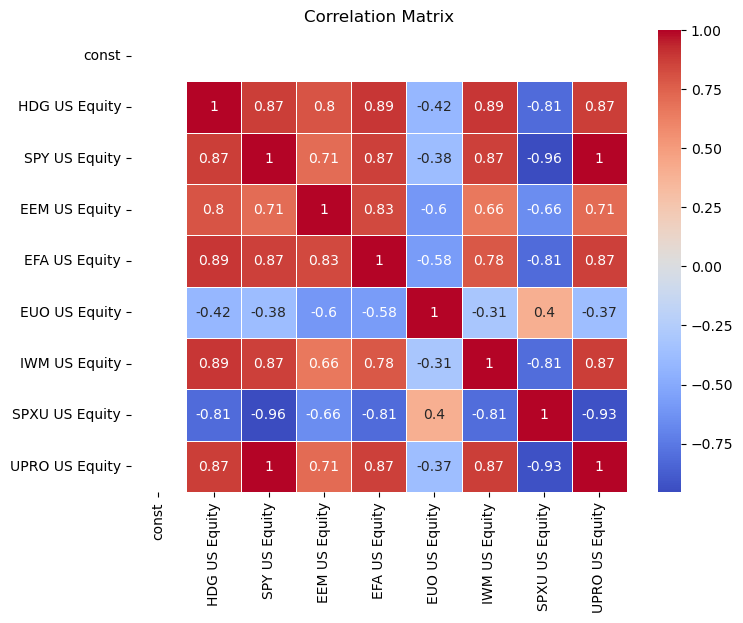

In [409]:
corrmatrix = X.corr()
plt.figure(figsize=(8, 6))  # Set the size of the heatmap
sns.heatmap(corrmatrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### 6.

Explain how good is your replication, pointing out at least one good or bad argument related to each of the statistics mentioned in the bullet points above (thus, you should have at least 4 arguments).

The R Squared is quite high, which shows it is a good replication. The information ratio is also very low, implying we performed really close to our target benchmark. The intercept is very small, which means we do not have to introduce a risk free rate to replicate and can use our basket of stocks. And finally, the absolute beta values add up to only one, which means we do not have outsized weights, meaning our replication is working quite well.

***

# 4. 

The data in sheet `fx carry excess returns` has **excess** daily returns for trading currencies.
* You **do NOT need** to know anything about FX, currency, or the underlying strategies.
* Rather, just take these return series as given.

For the problems below, we will **only use** the `JPY` series.

In [410]:
FILEIN = '../data/midterm_1_data.xlsx'
sheet_exrets = 'fx carry returns'
retfx = pd.read_excel(FILEIN, sheet_name=sheet_exrets).set_index('date')
retjpy = retfx[['JPY']]

retjpy.head()

,JPY
date,
2019-01-07,-0.001843
2019-01-08,-0.000324
2019-01-09,0.005222
2019-01-10,-0.002486
2019-01-11,-0.000865


### 1.

Calculate the `1%` VaR as follows...

Empirical VaR:
* At every point in time, calculate the `1st` quantile of the returns up to that point.
* No need to scale the answers.
  
Report the VaR for the final date of the sample.

In [411]:
#using my solitions to homework 3 for this 

def calculate_var_1percent(series):
    return series.quantile(0.01)
rolling_var = retjpy['JPY'].expanding().apply(calculate_var_1percent)
rolling_var.iloc[-1]

-0.01717837630807654

### 2.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* rolling volatility.
* using a window of `233` days.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [412]:
rolling_vol = retjpy['JPY'].rolling(window=233).std()
normal_var = -2.33 * rolling_vol
normal_var.tail(3)

date
2024-08-01   -0.013358
2024-08-02   -0.013646
2024-08-05   -0.013844
Name: JPY, dtype: float64

### 3.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* EWMA volatility
* using $\lambda = 0.94$.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [413]:
lambda_ewma = 0.94
ewma_vol = retjpy['JPY'].ewm(span=(1/(1 - lambda_ewma)), adjust=False).std()
normal_var_ewma = -2.33 * ewma_vol
normal_var_ewma.tail(3)

date
2024-08-01   -0.017406
2024-08-02   -0.019869
2024-08-05   -0.020179
Name: JPY, dtype: float64

### 4.

Make a plot of the three timeseries of your VaR estimates.

Succinctly point out the pros / cons of these approaches.

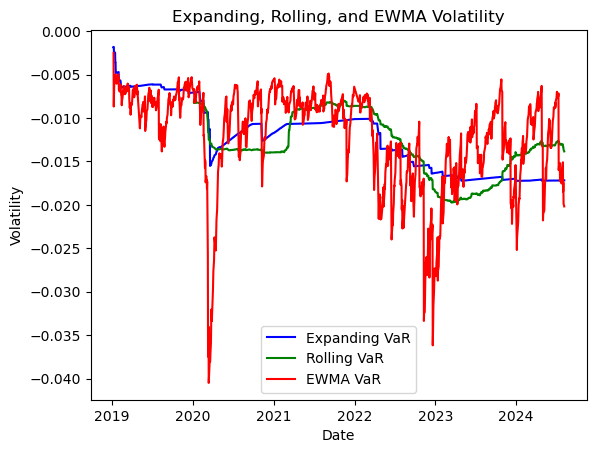

In [414]:
df = pd.DataFrame({
    'expanding var': rolling_var,
    'rolling var': normal_var,
    'ewma var': normal_var_ewma
})

plt.plot(df.index, df['expanding var'], label='Expanding VaR', color='blue')
plt.plot(df.index, df['rolling var'], label='Rolling VaR', color='green')
plt.plot(df.index, df['ewma var'], label='EWMA VaR', color='red')

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Expanding, Rolling, and EWMA Volatility')

plt.legend()

plt.show()

### 5.

What statistic do we use to judge the performance of a VaR model?

Estimate and report this statistic across the VaR methods.

Which VaR model do you find is best?

In [415]:
#using hw3 solutions and a gpt prompt: how to calulcate hit rates for VaR

retjpy_jpy = retjpy['JPY'].reindex(df.index)

expanding_hits = (retjpy_jpy < df['expanding var']).sum()
expanding_hit_rate = expanding_hits / len(retjpy_jpy)

rolling_hits = (retjpy_jpy < df['rolling var']).sum()
rolling_hit_rate = rolling_hits / len(retjpy_jpy)

ewma_hits = (retjpy_jpy < df['ewma var']).sum()
ewma_hit_rate = ewma_hits / len(retjpy_jpy)

print(f"Expanding VaR Hit Rate: {expanding_hit_rate:.4f}")
print(f"Rolling VaR Hit Rate: {rolling_hit_rate:.4f}")
print(f"EWMA VaR Hit Rate: {ewma_hit_rate:.4f}")


Expanding VaR Hit Rate: 0.0230
Rolling VaR Hit Rate: 0.0199
EWMA VaR Hit Rate: 0.0069


We want to assess VaR by looking at the "hit rate", or the amount of times our daily returns cross the thresholds we set with VaR. A lower value is best, which means that our EWMA VaR is the best model to use. We do want to keep in mind that too low of a hit rate means the model is too conservative, but in this case our EWMA is 0.7% and the next lowest is our Rolling VaR at 2.0%, so if we say the optimal hit rate is around 1%, then EWMA is still best.

***